In [1]:
import torch

import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram, AudioToMelSpectrogram, AudioToMFCCSpectrogram
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-03 11:25:47,199	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    "batch_size": tune.lograndint(16, 128),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003),
    "nmels" : tune.randint(64, 256),
    "nmfcc" : tune.randint(32, 128)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [4]:
concurrent_trials = 2

# Load  dataset
recording_path="F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
label_path="F:\\Persönliches\\Git\\BioOTon"
ds = SpectroDataset(recording_path, label_path, device = 'cuda')

trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds, spectro_mode = "atmfs"
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(train_model pid=30400) f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (191) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
(train_model pid=30400)   warnings.warn(


(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27912056_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27439041_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27496845_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27911985_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\28154697_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27908954_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\26847709_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22682739_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27579147_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27634778_audio.pt
(train_model pid=30400) Getting F:\Persönliches\Git\BioOTon\AudioTensors\27738220_audio.pt

(pid=gcs_server) [2026-01-03 11:26:15,193 E 10660 23232] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\25869009_audio.pt
(train_model pid=21472)  F:\Persönliches\Git\BioOTon\AudioTensors\27603830_audio.pt
(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\22867004_audio.pt
(train_model pid=21472) 
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\27669377_audio.pt
(train_model pid=21472) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22665761_audio.pt [repeated 3511x across cluster]
(train_model pid=30400)  
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\26780901_audio.pt
(train_model pid=21472) 81  :  24
(train_model pid=21472) 
(train_model pid=21472)  F:\Persönliches\Git\BioOTon\AudioTensors\19202771_audio.pt
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\26735495_audio.pt
(train_model pid=21472) [1,    25] loss: 97.880242 vloss: 3.066671
(train_model pid=30400)  
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\23391243_audio.pt
(train_m

(raylet) [2026-01-03 11:26:19,768 E 22624 32072] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=30400)  
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\27649830_audio.pt
(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\28312874_audio.pt
(train_model pid=30400)  F:\Persönliches\Git\BioOTon\AudioTensors\27773515_audio.pt
(train_model pid=30400)  F:\Persönliches\Git\BioOTon\AudioTensors\22423180_audio.pt
(train_model pid=30400)  F:\Persönliches\Git\BioOTon\AudioTensors\27724501_audio.pt
(train_model pid=30400) 
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\28410647_audio.pt
(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\27908954_audio.pt
(train_model pid=21472) 
(train_model pid=21472)  
(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\26814242_audio.pt
(train_model pid=21472) F:\Persönliches\Git\BioOTon\AudioTensors\22901045_audio.pt
(train_model pid=30400) F:\Persönliches\Git\BioOTon\AudioTensors\27586899_audio.pt
(train_model pid=30400) 
(train_model pid=21472) Getting F:\Persö

(train_model pid=14504) f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (221) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
(train_model pid=14504)   warnings.warn(


(train_model pid=26256) Getting  [repeated 2347x across cluster]
(train_model pid=26256) F:\Persönliches\Git\BioOTon\AudioTensors\23023266_audio.pt
(train_model pid=26256) 
(train_model pid=26256)  F:\Persönliches\Git\BioOTon\AudioTensors\28055386_audio.pt
(train_model pid=14504) 
(train_model pid=26256) 
(train_model pid=26256) 
(train_model pid=14504) F:\Persönliches\Git\BioOTon\AudioTensors\27972821_audio.pt
(train_model pid=26256) 
(train_model pid=14504) F:\Persönliches\Git\BioOTon\AudioTensors\27478742_audio.pt
(train_model pid=14504) F:\Persönliches\Git\BioOTon\AudioTensors\28115261_audio.pt
(train_model pid=26256) F:\Persönliches\Git\BioOTon\AudioTensors\23650320_audio.pt
(train_model pid=14504) 
(train_model pid=14504) F:\Persönliches\Git\BioOTon\AudioTensors\27752953_audio.pt
(train_model pid=14504) 
(train_model pid=26256) Getting F:\Persönliches\Git\BioOTon\AudioTensors\22707100_audio.pt [repeated 3160x across cluster]
(train_model pid=14504)  F:\Persönliches\Git\BioOTon\Au

2026-01-03 11:30:34,771	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2026-01-03 11:30:34,812	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0393s.


(train_model pid=14504)  
(train_model pid=14504) F:\Persönliches\Git\BioOTon\AudioTensors\22402225_audio.pt
(train_model pid=26256) Getting  [repeated 3026x across cluster]
(train_model pid=26256) F:\Persönliches\Git\BioOTon\AudioTensors\22743041_audio.pt
(train_model pid=26256)  F:\Persönliches\Git\BioOTon\AudioTensors\22298151_audio.pt
(train_model pid=26256) 
(train_model pid=26256)  
(train_model pid=26256) F:\Persönliches\Git\BioOTon\AudioTensors\26763144_audio.pt
(train_model pid=14504) 44  :  1
(train_model pid=26256) 64  :  31


2026-01-03 11:30:38,304	INFO tune.py:1041 -- Total run time: 286.38 seconds (282.82 seconds for the tuning loop).
2026-01-03 11:30:38,305	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)


(train_model pid=14504) [2,    46] loss: 21.834018 vloss: 2.205925
(train_model pid=26256)  F:\Persönliches\Git\BioOTon\AudioTensors\22897359_audio.pt
(train_model pid=26256) [5,    32] loss: 10.129429 vloss: 3.926852


ResultGrid<[
  Result(
    metrics={'loss': 1.9789237976074219, 'accuracy': 0.54},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_3d4780',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.8668148517608643, 'accuracy': 0.12},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_ad77aa',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.185589075088501, 'accuracy': 0.54},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_b6eba9',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.301802635192871, 'accuracy': 0.51},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_776fc2',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.15432870388031, 'accuracy': 0.23},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_006e81',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    me

In [ ]:
model, df = getBestModel(return_df=True)

In [ ]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

In [ ]:
train_indices, test_indices, val_indices  = splitDataset(ds)
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

Getting F:\Persönliches\Git\BioOTon\AudioTensors\23857077_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294964_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26223311_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294960_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22329529_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26574358_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22303197_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\23848329_audio.pt
Best Hyperparameters: {'lr': 0.00018217292899600795, 'batch_size': 2, 'nfft': 4096, 'scale': 3.3285967358612116, 'power': 1.7831184599879397, 'patience': 9, 'EarlyDelta': 0.0549733297167698, 'epochs': 17, 'l1': 0.003237281614796639, 'l2': 0.0015806433029207302}
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398674_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398677_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22370546_audio.pt
G

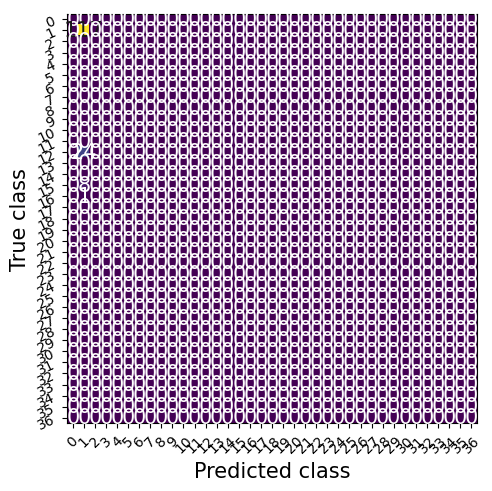

Recall of the custom cnn: tensor(0.2500, device='cuda:0')
F1-score of the custom cnn: tensor(0.2191, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.2500, device='cuda:0')


In [ ]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel()
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())